# Updating features in a feature layer

As content publishers, you may be required to keep certain web layers up to date. As new data arrives, you may have to append new features, update existing features etc. There are a couple of different options to accomplish this:
 
 - Method 1: editing individual features as updated datasets are available
 - Method 2: overwriting feature layers altogether with updated datasets
 
Depending on the number of features that are updated, your workflow requirements, you may adopt either or both kinds of update mechanisms.

In this sample, we explore the first method:

**Method 1**
 - [Updating feature layer by editing individual features](#Updating-feature-layer-by-editing-individual-features)
  - [Publish the cities feature layer using the initial dataset](#Publish-the-cities-feature-layer-using-the-initial-dataset)  
  - [Apply updates from the second spreadsheet](#Apply-updates-from-the-second-spreadsheet)
    - [Identifying existing features that need to be updated](#Identifying-existing-features-that-need-to-be-updated)
    - [Perform updates to the existing features](#Perform-updates-to-the-existing-features)
    - [Identifying new features that need to be added](#Identifying-new-features-that-need-to-be-added)
    - [Adding new features](#Adding-new-features)   
  - [Apply edits from third spreadsheet](#Apply-edits-from-third-spreadsheet)
    - [Inspecting existing fields of the feature layer](#Inspecting-existing-fields-of-the-feature-layer)
    - [Preparing additional columns to add to the feature layer](#Preparing-additional-columns-to-add-to-the-feature-layer)
    - [Adding additional columns to the feature layer](#Adding-additional-fields-to-the-feature-layer)
    - [Adding attribute values to the new columns](#Adding-attribute-values-to-the-new-columns)

For **Method 2**, refer to the sample titled [Overwriting feature layers](https://developers.arcgis.com/python/sample-notebooks/overwriting-feature-layers)

**Note**: To run this sample, you need the ``pandas`` library in your conda environment. If you don't have the library, install it by running the following command from cmd.exe or your shell
```
conda install pandas```

In [3]:
# Connect to the GIS
from arcgis.gis import GIS
from arcgis import features
import pandas as pd

In [4]:
#Access the portal using "amazing_arcgis_123" as password for the given Username. 
gis = GIS("https://python.playground.esri.com/portal", "arcgis_python")

Enter password: ········


## Updating feature layer by editing individual features

Let us consider a scenario where we need to update a feature layer containing the capital cities of the US. We have 3 csv datasets simulating an update workflow as described below:

 1. capitals_1.csv -- contains the initial, incomplete dataset
 2. capitals_2.csv -- contains additional points and updates to existing points, building on top of capitals_1.csv
 3. capitals_annex.csv -- an alternate table containing additional attribute information
 
Our goal is to update the feature layer with each of these datasets doing the necessary edit operations.

### Publish the cities feature layer using the initial dataset

In [5]:
# read the initial csv
csv1 = 'data/updating_gis_content/capitals_1.csv'
cities_df_1 = pd.read_csv(csv1)
cities_df_1.head()

city_id        name state capital  pop2000  pop2007   longitude   latitude
0        1    Honolulu    HI   State   371657   378587 -157.823436  21.305782
1        2      Juneau    AK   State    30711    31592 -134.511582  58.351418
2        3  Boise City    ID   State   185787   203529 -116.237655  43.613736
3        4     Olympia    WA   State    27514    45523 -122.893073  47.042418
4        5       Salem    OR   State   136924   152039 -123.029155  44.931109

In [6]:
# print the number of records in this csv
cities_df_1.shape

(19, 8)

As you can see, this dataset only contains 19 rows or 19 capital cities. It is not the complete dataset.

Let's add this `csv` as a portal item. Adding the item creates a CSV item and uploads the original file to the portal, establishing a link between the item and the original file name. Therefore, we need a unique name for the file to guarantee it does not collide with any file of the same name that may have been uploaded by the same user. We'll use standard library modules to copy the file and give it a new name so we can add it to the portal

In [7]:
import os
import datetime as dt
import shutil

# assign variables to locations on the file system 
cwd = os.path.abspath(os.getcwd())
data_pth = os.path.join(cwd, r'data/updating_gis_content/')

# create a unique timestamp string to append to the file name
now_ts = str(int(dt.datetime.now().timestamp()))

# copy the file, appending the unique string and assign it to a variable
my_csv = shutil.copyfile(os.path.abspath(csv1),
                        os.path.join(data_pth, 'capitals_1_' + now_ts + '.csv'))

In [8]:
my_csv

'\\path\\on\\computer\\05_content_publishers\\data/updating_gis_content/capitals_1_1548875507.csv'

In [9]:
# add the initial csv file and publish that as a web layer
item_prop = {'title':'USA Capitals spreadsheet ' + now_ts}
csv_item = gis.content.add(item_properties=item_prop, data=my_csv)
csv_item

<Item title:"USA Capitals spreadsheet 1548875507" type:CSV owner:arcgis_python>

This spreadsheet has co-ordinates as `latitude` and `longitude` columns which will be used for geometries during publishing.

In [10]:
# publish the csv item into a feature layer
cities_item = csv_item.publish()
cities_item

<Item title:"USA Capitals spreadsheet 1548875507" type:Feature Layer Collection owner:arcgis_python>

<Item title:"USA Capitals" type:Feature Layer Collection owner:arcgis_python>
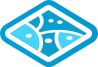

In [19]:
# update the item metadata
item_prop = {'title':'USA Capitals'}
cities_item.update(item_properties = item_prop, thumbnail='data/updating_gis_content/capital_cities.png')
cities_item

### Apply updates from the second spreadsheet
The next set of updates have arrived and are stored in `capitals_2.csv`. We are told it contains corrections for the original set in addition to new features. We need to figure out which rows have changed, apply `update` operation on those, then apply `add` operation to new rows.

To start with, let us read the second csv file. Note, in this sample, data is stored in csv. In reality, it could be from your enterprise database or any other data source.

In [11]:
# read the second csv set
csv2 = 'data/updating_gis_content/capitals_2.csv'
cities_df_2 = pd.read_csv(csv2)
cities_df_2.head()

city_id         name state capital  pop2000  pop2007   longitude   latitude
0       20  Baton Rouge    LA   State   227818   228810  -91.140227  30.458091
1       21       Helena    MT   State    25780    26007 -112.027027  46.595809
2       22     Bismarck    ND   State    55532    59344 -100.779000  46.813346
3       23       Pierre    SD   State    13876    14169 -100.336382  44.367964
4       24     St. Paul    MN   State   287151   291643  -93.114118  44.954364

In [12]:
# get the dimensions of this csv
cities_df_2.shape

(36, 8)

#### Identifying existing features that need to be updated

To identify features that need to be updated, let us read the attribute table of the published feature layer and compare that against the second csv. To read the attribute table, we perform a `query()` on the feature layer which returns us an `arcgis.feature.FeatureSet` object. Refer to the guide pages on [accessing features from feature layers](https://developers.arcgis.com/python/guide/working-with-feature-layers-and-features/) to learn more about this.

Note, at this point, we could work with the `cities_df_1` dataframe we created from the original csv file. However, in practice you may not always have the original dataset or your feature layer might have undergone edits after it was published. Hence, we query the feature layer directly.

In [13]:
cities_flayer = cities_item.layers[0]
cities_fset = cities_flayer.query() #querying without any conditions returns all the features
cities_fset.sdf.head()

SHAPE capital  city_id  \
0  {"x": -17568824.553, "y": 2428377.352700006, "...   State        1   
1  {"x": -14973760.769500002, "y": 8041504.674200...   State        2   
2  {"x": -12939516.521100001, "y": 5405860.248099...   State        3   
3  {"x": -13680394.263900002, "y": 5949000.547900...   State        4   
4  {"x": -13695542.842799995, "y": 5610682.544100...   State        5   

    latitude   longitude        name  objectid  pop2000  pop2007 state  
0  21.305782 -157.823436    Honolulu         1   371657   378587    HI  
1  58.351418 -134.511582      Juneau         2    30711    31592    AK  
2  43.613736 -116.237655  Boise City         3   185787   203529    ID  
3  47.042418 -122.893073     Olympia         4    27514    45523    WA  
4  44.931109 -123.029155       Salem         5   136924   152039    OR

The `city_id` column is common between both the datasets. Next, let us perform an `inner` join with the table from feature layer as left and updated csv as right. Inner joins will yield those rows that are present in both tables. Learn more about [inner joins here](https://www.w3schools.com/sql/sql_join_inner.asp).

In [14]:
overlap_rows = pd.merge(left = cities_fset.sdf, right = cities_df_2, how='inner',
                       on = 'city_id')
overlap_rows

SHAPE capital_x  city_id  \
0  {'x': -13680394.263900002, 'y': 5949000.547900...     State        4   
1  {'x': 11666510.350300007, 'y': -5033833.302499...     State       10   
2  {'x': -10857545.543799996, 'y': 4229619.674200...     State       13   
3  {'x': -10421826.864700003, 'y': 5099899.263700...     State       16   

   latitude_x  longitude_x         name_x  objectid  pop2000_x  pop2007_x  \
0   47.042418  -122.893073        Olympia         4      27514      45523   
1  -41.145545   104.802046       Cheyenne        10      53011      54750   
2   35.482309   -97.534991  Oklahoma City        13     506132     552556   
3   41.590936   -93.620864     Des Moines        16     200682     201257   

  state_x         name_y state_y capital_y  pop2000_y  pop2007_y  longitude_y  \
0      WA        Olympia      WA     State      42514      45523  -122.893073   
1      WY       Cheyenne      WY     State      53011      54750  -104.802046   
2     OKK  Oklahoma City      OK     State     506132     552556   -97.534991   
3      IA     Des Moines      IA     State     198682     201257   -93.620864   

   latitude_y  
0   47.042418  
1   41.145545  
2   35.482309  
3   41.590936

Thus, of 19 features in original and 36 features in second csv, 4 features are common. Inspecting the table, we find certain columns are updated, for instance, Cheyenne has its coordinates corrected, Oklahoma City has its state abbreviation corrected and similarly other cities have one of their attribute columns updated.

We could either update individual attribute values for these 4 features or update all attribute values with the latest csv. Below, we are performing the latter as it is simple and fast.

#### Perform updates to the existing features

In [15]:
features_for_update = [] #list containing corrected features
all_features = cities_fset.features

In [16]:
# inspect one of the features
all_features[0]

{"geometry": {"x": -17568824.553, "y": 2428377.352700006, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"objectid": 1, "city_id": 1, "name": "Honolulu", "state": "HI", "capital": "State", "pop2000": 371657, "pop2007": 378587, "longitude": -157.8234362, "latitude": 21.30578163, "SHAPE": {"x": -17568824.553, "y": 2428377.352700006, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}

Note the X and Y geometry values are different from decimal degree coordinates present in Longitude and Latitude fields. To perform geometry edits, we need to project the coordinates to match that of the feature layer.

In [17]:
# get the spatial reference of the features since we need to update the geometry
cities_fset.spatial_reference

{'wkid': 102100, 'latestWkid': 3857}

Below, we prepare updated geometries and attributes for each of the 4 features we determined above. We use the `arcgis.geometry` module to `project` the coordinates from geographic to projected coordinate system. The cell below prints the original `Feature` objects followed by the updated ones. If you look closely, you can find the differences.

In [18]:
from arcgis import geometry #use geometry module to project Long,Lat to X and Y
from copy import deepcopy

for city_id in overlap_rows['city_id']:
    # get the feature to be updated
    original_feature = [f for f in all_features if f.attributes['city_id'] == city_id][0]
    feature_to_be_updated = deepcopy(original_feature)
    
    print(str(original_feature))
    
    # get the matching row from csv
    matching_row = cities_df_2.where(cities_df_2.city_id == city_id).dropna()
    
    #get geometries in the destination coordinate system
    input_geometry = {'y':float(matching_row['latitude']),
                       'x':float(matching_row['longitude'])}
    output_geometry = geometry.project(geometries = [input_geometry],
                                       in_sr = 4326, 
                                       out_sr = cities_fset.spatial_reference['latestWkid'],
                                      gis = gis)
    
    # assign the updated values
    feature_to_be_updated.geometry = output_geometry[0]
    feature_to_be_updated.attributes['longitude'] = float(matching_row['longitude'])
    feature_to_be_updated.attributes['city_id'] = int(matching_row['city_id'])
    feature_to_be_updated.attributes['state'] = matching_row['state'].values[0]
    feature_to_be_updated.attributes['capital'] = matching_row['capital'].values[0]
    feature_to_be_updated.attributes['latitude'] = float(matching_row['latitude'])
    feature_to_be_updated.attributes['name'] = matching_row['name'].values[0]
    feature_to_be_updated.attributes['pop2000'] = int(matching_row['pop2000'])
    feature_to_be_updated.attributes['pop2007'] = int(matching_row['pop2007'])
    
    #add this to the list of features to be updated
    features_for_update.append(feature_to_be_updated)
    
    print(str(feature_to_be_updated))
    print("========================================================================")

{"geometry": {"x": -13680394.263900002, "y": 5949000.547900006, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"objectid": 4, "city_id": 4, "name": "Olympia", "state": "WA", "capital": "State", "pop2000": 27514, "pop2007": 45523, "longitude": -122.8930726, "latitude": 47.04241817, "SHAPE": {"x": -13680394.263900002, "y": 5949000.547900006, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -13680394.2638528, "y": 5949000.54792491}, "attributes": {"objectid": 4, "city_id": 4, "name": "Olympia", "state": "WA", "capital": "State", "pop2000": 42514, "pop2007": 45523, "longitude": -122.8930726, "latitude": 47.04241817, "SHAPE": {"x": -13680394.263900002, "y": 5949000.547900006, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": 11666510.350300007, "y": -5033833.302499998, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"objectid": 10, "city_id": 10, "name": "Cheyenne", "state": "WY",

We have constructed a list of features with updated values. We can use this list to perform updates on the feature layer.

In [19]:
features_for_update

[{"geometry": {"x": -13680394.2638528, "y": 5949000.54792491}, "attributes": {"objectid": 4, "city_id": 4, "name": "Olympia", "state": "WA", "capital": "State", "pop2000": 42514, "pop2007": 45523, "longitude": -122.8930726, "latitude": 47.04241817, "SHAPE": {"x": -13680394.263900002, "y": 5949000.547900006, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}},
 {"geometry": {"x": -11666510.350285435, "y": 5033833.302497153}, "attributes": {"objectid": 10, "city_id": 10, "name": "Cheyenne", "state": "WY", "capital": "State", "pop2000": 53011, "pop2007": 54750, "longitude": -104.80204559999999, "latitude": 41.14554516, "SHAPE": {"x": 11666510.350300007, "y": -5033833.302499998, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}},
 {"geometry": {"x": -10857545.54377847, "y": 4229619.674165817}, "attributes": {"objectid": 13, "city_id": 13, "name": "Oklahoma City", "state": "OK", "capital": "State", "pop2000": 506132, "pop2007": 552556, "longitude": -97.5349911, "latitude": 

To update the feature layer, call the `edit_features()` method of the `FeatureLayer` object and pass the list of features to the `updates` parameter:

In [20]:
cities_flayer.edit_features(updates= features_for_update)

{'addResults': [],
 'updateResults': [{'objectId': 4, 'globalId': None, 'success': True},
  {'objectId': 10, 'globalId': None, 'success': True},
  {'objectId': 13, 'globalId': None, 'success': True},
  {'objectId': 16, 'globalId': None, 'success': True}],
 'deleteResults': [],
 'attachments': {'addResults': [], 'updateResults': [], 'deleteResults': []}}

We have successfully applied corrections to those features which existed in the feature layer from the initial dataset. Next let us proceed to adding new features present only in the second csv file.

#### Identifying new features that need to be added

In [21]:
#select those rows in the capitals_2.csv that do not overlap with those in capitals_1.csv
new_rows = cities_df_2[~cities_df_2['city_id'].isin(overlap_rows['city_id'])]
print(new_rows.shape)

(32, 8)


In [22]:
new_rows.head()

city_id         name state capital  pop2000  pop2007   longitude   latitude
0       20  Baton Rouge    LA   State   227818   228810  -91.140227  30.458091
1       21       Helena    MT   State    25780    26007 -112.027027  46.595809
2       22     Bismarck    ND   State    55532    59344 -100.779000  46.813346
3       23       Pierre    SD   State    13876    14169 -100.336382  44.367964
4       24     St. Paul    MN   State   287151   291643  -93.114118  44.954364

Thus, of the total 36 rows in the second csv, we have determined the 32 other rows which are new and need to be appended as new features.

#### Adding new features
Next, let us compose another `list` of `Feature` objects similar to earlier, from the `new_rows` data frame.

In [23]:
features_to_be_added = []

# get a template feature object
template_feature = deepcopy(features_for_update[0])

# loop through each row and add to the list of features to be added
for row in new_rows.iterrows():
    new_feature = deepcopy(template_feature)
    
    #print
    print("Creating " + row[1]['name'])
    
    #get geometries in the destination coordinate system
    input_geometry = {'y':float(row[1]['latitude']),
                       'x':float(row[1]['longitude'])}
    output_geometry = geometry.project(geometries = [input_geometry],
                                       in_sr = 4326, 
                                       out_sr = cities_fset.spatial_reference['latestWkid'],
                                      gis = gis)
    
    # assign the updated values
    new_feature.geometry = output_geometry[0]
    new_feature.attributes['longitude'] = float(row[1]['longitude'])
    new_feature.attributes['city_id'] = int(row[1]['city_id'])
    new_feature.attributes['state'] = row[1]['state']
    new_feature.attributes['capital'] = row[1]['capital']
    new_feature.attributes['latitude'] = float(row[1]['latitude'])
    new_feature.attributes['name'] = row[1]['name']
    new_feature.attributes['pop2000'] = int(row[1]['pop2000'])
    new_feature.attributes['pop2007'] = int(row[1]['pop2007'])
    
    #add this to the list of features to be updated
    features_to_be_added.append(new_feature)

Creating Baton Rouge
Creating Helena
Creating Bismarck
Creating Pierre
Creating St. Paul
Creating Madison
Creating Lansing
Creating Augusta
Creating Montpelier
Creating Albany
Creating Boston
Creating Concord
Creating Tallahassee
Creating Jackson
Creating Nashville
Creating Montgomery
Creating Springfield
Creating Indianapolis
Creating Frankfort
Creating Columbus
Creating Charleston
Creating Atlanta
Creating Columbia
Creating Raleigh
Creating Richmond
Creating Harrisburg
Creating Trenton
Creating Dover
Creating Washington
Creating Annapolis
Creating Hartford
Creating Providence


In [24]:
# take a look at one of the features we created
features_to_be_added[0]

{"geometry": {"x": -10145683.671555312, "y": 3562570.141302621}, "attributes": {"objectid": 4, "city_id": 20, "name": "Baton Rouge", "state": "LA", "capital": "State", "pop2000": 227818, "pop2007": 228810, "longitude": -91.14022709999999, "latitude": 30.45809113, "SHAPE": {"x": -13680394.263900002, "y": 5949000.547900006, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}

Thus, we have created a `list` of `Feature` objects with appropriate attributes and geometries. Next, to add these new features to the feature layer, call the `edit_features()` method of the `FeatureLayer` object and pass the list of `Feature` objects to the `adds` parameter:

In [25]:
cities_flayer.edit_features(adds = features_to_be_added)

{'addResults': [{'objectId': 20, 'globalId': None, 'success': True},
  {'objectId': 21, 'globalId': None, 'success': True},
  {'objectId': 22, 'globalId': None, 'success': True},
  {'objectId': 23, 'globalId': None, 'success': True},
  {'objectId': 24, 'globalId': None, 'success': True},
  {'objectId': 25, 'globalId': None, 'success': True},
  {'objectId': 26, 'globalId': None, 'success': True},
  {'objectId': 27, 'globalId': None, 'success': True},
  {'objectId': 28, 'globalId': None, 'success': True},
  {'objectId': 29, 'globalId': None, 'success': True},
  {'objectId': 30, 'globalId': None, 'success': True},
  {'objectId': 31, 'globalId': None, 'success': True},
  {'objectId': 32, 'globalId': None, 'success': True},
  {'objectId': 33, 'globalId': None, 'success': True},
  {'objectId': 34, 'globalId': None, 'success': True},
  {'objectId': 35, 'globalId': None, 'success': True},
  {'objectId': 36, 'globalId': None, 'success': True},
  {'objectId': 37, 'globalId': None, 'success': Tru

Thus, we have successfully applied edits from second csv file. Next let us look at how we can apply edits from third csv file.

### Apply edits from third spreadsheet
The next set of updates have arrived and are stored in `capitals_annex.csv`. We are told it contains additional columns for each of the features that we want to add to the feature layer.

To start with, let us read the third csv file. Note in this sample, data is stored in csv. In reality, it could be from your enterprise database or any other data source.

In [26]:
# read the third csv set
csv3 = 'data/updating_gis_content/capitals_annex.csv'
cities_df_3 = pd.read_csv(csv3)
cities_df_3.head()

city_id        name                    class   white  black  ameri_es  \
0        1    Honolulu  Census Designated Place   73093   6038       689   
1        2      Juneau         City and Borough   22969    248      3496   
2        3  Boise City                     City  171204   1437      1300   
3        4     Olympia                     City   36246    805       553   
4        5       Salem                     City  113746   1750      2064   

    asian  hawn_pl  hispanic   males  females  
0  207588    25457     16229  182628   189029  
1    1438      116      1040   15469    15242  
2    3870      302      8410   92014    93773  
3    2473      125      1863   20319    22195  
4    3304      643     19973   68752    68172

In [27]:
#find the number of rows in the third csv
cities_df_3.shape

(51, 11)

The `capitals_annex.csv` does not add new features, instead it adds additional attribute columns to existing features. It has 51 rows which were found to match the 19 + 32 rows from first and second csv files. The columns `City_ID` and `NAME` are common to all 3 spreadsheets. Next let us take a look at how we can append this additional attribute information to our feature layer.

#### Inspecting existing fields of the feature layer
The `manager` property of the `FeatureLayer` object exposes a set of methods to read and update the properties and definition of feature layers.

In [28]:
#Get the existing list of fields on the cities feature layer
cities_fields = cities_flayer.manager.properties.fields

# Your feature layer may have multiple fields, 
# instead of printing all, let us take a look at one of the fields:
cities_fields[1]

{
  "name": "city_id",
  "type": "esriFieldTypeInteger",
  "alias": "city_id",
  "domain": null,
  "editable": true,
  "nullable": true,
  "sqlType": "sqlTypeInteger",
  "length": 10
}

From above, we can see the representation of one of the fields. Let us loop through each of the fields and print the `name`, `alias`, `type` and `sqlType` properties

In [29]:
for field in cities_fields:
    print(f"{field.name:13}|  {field.alias:13}|  {field.type:25}|  {field.sqlType}")

objectid     |  objectid     |  esriFieldTypeOID         |  sqlTypeInteger
city_id      |  city_id      |  esriFieldTypeInteger     |  sqlTypeInteger
name         |  name         |  esriFieldTypeString      |  sqlTypeVarchar
state        |  state        |  esriFieldTypeString      |  sqlTypeVarchar
capital      |  capital      |  esriFieldTypeString      |  sqlTypeVarchar
pop2000      |  pop2000      |  esriFieldTypeInteger     |  sqlTypeInteger
pop2007      |  pop2007      |  esriFieldTypeInteger     |  sqlTypeInteger
longitude    |  longitude    |  esriFieldTypeDouble      |  sqlTypeNumeric
latitude     |  latitude     |  esriFieldTypeDouble      |  sqlTypeNumeric


#### Preparing additional columns to add to the feature layer
Now that we have an idea of how the fields are defined, we can go ahead and append new fields to the layer's definition. Once we compose a list of new fields, by calling the `add_to_definition()` method we can push those changes to the feature layer. Once the feature layer's definition is updated with new fields, we can loop through each feature and add the appropriate attribute values.

To compose a list of new fields to be added, we start by making a copy of one of the fields as a template and start editing it. One easy part in this example is, all new fields that need to be added except one, are of the same data type: integer. With your data, this may not be the case. In such instances, you can add each field individually.

In [30]:
# get a template field
template_field = dict(deepcopy(cities_fields[1]))
template_field

{'name': 'city_id',
 'type': 'esriFieldTypeInteger',
 'alias': 'city_id',
 'domain': None,
 'editable': True,
 'nullable': True,
 'sqlType': 'sqlTypeInteger',
 'length': 10}

Let us use pandas to get the list of fields that are **new** in spread sheet 3

In [31]:
# get the list of new fields to add from the third spreadsheet, that are not in spread sheets 1,2
new_field_names = list(cities_df_3.columns.difference(cities_df_1.columns))
new_field_names

['ameri_es',
 'asian',
 'black',
 'class',
 'females',
 'hawn_pl',
 'hispanic',
 'males',
 'white']

Now loop though each new field name and create a field dictionary using the template we created earlier. Except the field titled `class` all other fields are of type `integer`.

In [32]:
fields_to_be_added = []
for new_field_name in new_field_names:
    current_field = deepcopy(template_field)
    if new_field_name.lower() == 'class':
        current_field['sqlType'] = 'sqlTypeVarchar'
        current_field['type'] = 'esriFieldTypeString'
        current_field['length'] = 8000
    current_field['name'] = new_field_name.lower()
    current_field['alias'] = new_field_name
    fields_to_be_added.append(current_field)
    
len(fields_to_be_added)

9

In [33]:
#inspect one of the fields
fields_to_be_added[3]

{'name': 'class',
 'type': 'esriFieldTypeString',
 'alias': 'class',
 'domain': None,
 'editable': True,
 'nullable': True,
 'sqlType': 'sqlTypeVarchar',
 'length': 8000}

#### Adding additional fields to the feature layer
The list of new fields we composed can be pushed to the server by calling `add_to_definition()` method on the `manager` property.

In [34]:
cities_flayer.manager.add_to_definition({'fields':fields_to_be_added})

{'success': True}

Thus, we have successfully added new fields to our feature layer. Let us verify the new columns show up:

In [35]:
new_cities_fields = cities_flayer.manager.properties.fields
len(new_cities_fields)

18

In [36]:
for field in new_cities_fields:
    print(f"{field.name:10}|  {field.type}")

objectid  |  esriFieldTypeOID
city_id   |  esriFieldTypeInteger
name      |  esriFieldTypeString
state     |  esriFieldTypeString
capital   |  esriFieldTypeString
pop2000   |  esriFieldTypeInteger
pop2007   |  esriFieldTypeInteger
longitude |  esriFieldTypeDouble
latitude  |  esriFieldTypeDouble
ameri_es  |  esriFieldTypeInteger
asian     |  esriFieldTypeInteger
black     |  esriFieldTypeInteger
class     |  esriFieldTypeString
females   |  esriFieldTypeInteger
hawn_pl   |  esriFieldTypeInteger
hispanic  |  esriFieldTypeInteger
males     |  esriFieldTypeInteger
white     |  esriFieldTypeInteger


#### Adding attribute values to the new columns
Next we can loop through each row in the third csv and add the new attribute values for these newly created columns.

In [37]:
# Run a fresh query on the feature layer so it includes the new features from
# csv2 and new columns from csv3
cities_fset2 = cities_flayer.query()
cities_features2 = cities_fset2.features

Loop through each row in the third spreadsheet, find the corresponding feature by matching the `city_id` value and apply the attribute values for the new fields.

In [38]:
features_for_update = []
for city_id in cities_df_3['city_id']:
    # get the matching row from csv
    matching_row = cities_df_3.where(cities_df_3.city_id == city_id).dropna()
    
    print(str(city_id) + " Adding additional attributes for: " + matching_row['name'].values[0])
    
    # get the feature to be updated
    original_feature = [f for f in cities_features2 if f.attributes['city_id'] == city_id][0]
    feature_to_be_updated = deepcopy(original_feature)
    
    # assign the updated values
    feature_to_be_updated.attributes['class'] = matching_row['class'].values[0]
    feature_to_be_updated.attributes['white'] = int(matching_row['white'])
    feature_to_be_updated.attributes['black'] = int(matching_row['black'])
    feature_to_be_updated.attributes['ameri_es'] = int(matching_row['ameri_es'])
    feature_to_be_updated.attributes['asian'] = int(matching_row['asian'])
    feature_to_be_updated.attributes['hawn_pl'] = int(matching_row['hawn_pl'])
    feature_to_be_updated.attributes['hispanic'] = int(matching_row['hispanic'])
    feature_to_be_updated.attributes['males'] = int(matching_row['males'])
    feature_to_be_updated.attributes['females'] = int(matching_row['females'])
    
    #add this to the list of features to be updated
    features_for_update.append(feature_to_be_updated)

1 Adding additional attributes for: Honolulu
2 Adding additional attributes for: Juneau
3 Adding additional attributes for: Boise City
4 Adding additional attributes for: Olympia
5 Adding additional attributes for: Salem
6 Adding additional attributes for: Carson
7 Adding additional attributes for: Sacramento
8 Adding additional attributes for: Phoenix
9 Adding additional attributes for: Salt Lake City
10 Adding additional attributes for: Cheyenne
11 Adding additional attributes for: Denver
12 Adding additional attributes for: Santa Fe
13 Adding additional attributes for: Oklahoma City
14 Adding additional attributes for: Topeka
15 Adding additional attributes for: Lincoln
16 Adding additional attributes for: Des Moines
17 Adding additional attributes for: Jefferson City
18 Adding additional attributes for: Little Rock
19 Adding additional attributes for: Austin
20 Adding additional attributes for: Baton Rouge
21 Adding additional attributes for: Helena
22 Adding additional attributes 

In [39]:
# inspect one of the features
features_for_update[-1]

{"geometry": {"x": -7950674.8190312665, "y": 5134585.3226086125}, "attributes": {"objectid": 51, "city_id": 51, "name": "Providence", "state": "RI", "capital": "State", "pop2000": 173618, "pop2007": 183731, "longitude": -71.42212709, "latitude": 41.82355466, "ameri_es": 1975, "asian": 10432, "black": 25243, "class": "City", "females": 90583, "hawn_pl": 270, "hispanic": 52146, "males": 83035, "white": 94666}}

In [40]:
# apply the edits to the feature layer
cities_flayer.edit_features(updates= features_for_update)

{'addResults': [],
 'updateResults': [{'objectId': 1, 'globalId': None, 'success': True},
  {'objectId': 2, 'globalId': None, 'success': True},
  {'objectId': 3, 'globalId': None, 'success': True},
  {'objectId': 4, 'globalId': None, 'success': True},
  {'objectId': 5, 'globalId': None, 'success': True},
  {'objectId': 6, 'globalId': None, 'success': True},
  {'objectId': 7, 'globalId': None, 'success': True},
  {'objectId': 8, 'globalId': None, 'success': True},
  {'objectId': 9, 'globalId': None, 'success': True},
  {'objectId': 10, 'globalId': None, 'success': True},
  {'objectId': 11, 'globalId': None, 'success': True},
  {'objectId': 12, 'globalId': None, 'success': True},
  {'objectId': 13, 'globalId': None, 'success': True},
  {'objectId': 14, 'globalId': None, 'success': True},
  {'objectId': 15, 'globalId': None, 'success': True},
  {'objectId': 16, 'globalId': None, 'success': True},
  {'objectId': 17, 'globalId': None, 'success': True},
  {'objectId': 18, 'globalId': None, '

#### Verify the changes made so far
Let us run another query on the feature layer and visualize a few rows.

In [41]:
cities_fset3 = cities_flayer.query()
cities_fset3.sdf.head(5)

SHAPE  ameri_es   asian  black  \
0  {"x": -17568824.553, "y": 2428377.352700006, "...       689  207588   6038   
1  {"x": -14973760.769500002, "y": 8041504.674200...      3496    1438    248   
2  {"x": -12939516.521100001, "y": 5405860.248099...      1300    3870   1437   
3  {"x": -13680394.263852797, "y": 5949000.547924...       553    2473    805   
4  {"x": -13695542.842799995, "y": 5610682.544100...      2064    3304   1750   

  capital  city_id                    class  females  hawn_pl  hispanic  \
0   State        1  Census Designated Place   189029    25457     16229   
1   State        2         City and Borough    15242      116      1040   
2   State        3                     City    93773      302      8410   
3   State        4                     City    22195      125      1863   
4   State        5                     City    68172      643     19973   

    latitude   longitude   males        name  objectid  pop2000  pop2007  \
0  21.305782 -157.823436  182628    Honolulu         1   371657   378587   
1  58.351418 -134.511582   15469      Juneau         2    30711    31592   
2  43.613736 -116.237655   92014  Boise City         3   185787   203529   
3  47.042418 -122.893073   20319     Olympia         4    42514    45523   
4  44.931109 -123.029155   68752       Salem         5   136924   152039   

  state   white  
0    HI   73093  
1    AK   22969  
2    ID  171204  
3    WA   36246  
4    OR  113746

## Conclusion
In this sample, we observed an edit intensive method to keep feature layers updated. We published data from first spreadsheet as a feature layer. We then updated existing features from second spread sheet (used geometry module to project the coordinates in the process), and added new features. The third spreadsheet presented additional attribute columns which were added to the feature layer by editing its definition and then updating the features with this additional data.

This method is editing intensive and you may choose this when the number of features to edit is less or if you needed to selectively update certain features as updates come in.

An alternate method is to overwrite the feature layer altogether when you always have current information coming in. This method is explained in the sample [Overwriting feature layers](https://developers.arcgis.com/python/sample-notebooks/overwriting-feature-layers)